<a href="https://colab.research.google.com/github/Voland24/AndrewNGDeepLearningCourse/blob/main/Week2Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Helper methods

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sklearn
import sklearn.datasets
import sklearn.linear_model
import scipy.io


def sigmoid(x):
    """
    Compute the sigmoid of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(x)
    """
    s = 1 / (1 + np.exp(-x))
    return s


def relu(x):
    """
    Compute the relu of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- relu(x)
    """
    s = np.maximum(0, x)

    return s


def load_planar_dataset(seed):
    np.random.seed(seed)

    m = 400  # number of examples
    N = int(m / 2)  # number of points per class
    D = 2  # dimensionality
    X = np.zeros((m, D))  # data matrix where each row is a single example
    Y = np.zeros((m, 1), dtype='uint8')  # labels vector (0 for red, 1 for blue)
    a = 4  # maximum ray of the flower

    for j in range(2):
        ix = range(N * j, N * (j + 1))
        t = np.linspace(j * 3.12, (j + 1) * 3.12, N) + np.random.randn(N) * 0.2  # theta
        r = a * np.sin(4 * t) + np.random.randn(N) * 0.2  # radius
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y


def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    b1 -- bias vector of shape (layer_dims[l], 1)
                    Wl -- weight matrix of shape (layer_dims[l-1], layer_dims[l])
                    bl -- bias vector of shape (1, layer_dims[l])
                    
    Tips:
    - For example: the layer_dims for the "Planar Data classification model" would have been [2,2,1]. 
    This means W1's shape was (2,2), b1 was (1,2), W2 was (2,1) and b2 was (1,1). Now you have to generalize it!
    - In the for loop, use parameters['W' + str(l)] to access Wl, where l is the iterative integer.
    """

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)  # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) / np.sqrt(layer_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l - 1])
        assert (parameters['W' + str(l)].shape == layer_dims[l], 1)

    return parameters


def forward_propagation(X, parameters):
    """
    Implements the forward propagation (and computes the loss) presented in Figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape ()
                    b1 -- bias vector of shape ()
                    W2 -- weight matrix of shape ()
                    b2 -- bias vector of shape ()
                    W3 -- weight matrix of shape ()
                    b3 -- bias vector of shape ()
    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    """

    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]

    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)

    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)

    return A3, cache


def backward_propagation(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache

    dZ3 = A3 - Y
    dW3 = 1. / m * np.dot(dZ3, A2.T)
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)

    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1. / m * np.dot(dZ2, A1.T)
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1. / m * np.dot(dZ1, X.T)
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}

    return gradients


def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(i)] = Wi
                    parameters['b' + str(i)] = bi
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(i)] = dWi
                    grads['db' + str(i)] = dbi
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    n = len(parameters) // 2  # number of layers in the neural networks

    # Update rule for each parameter
    for k in range(n):
        parameters["W" + str(k + 1)] = parameters["W" + str(k + 1)] - learning_rate * grads["dW" + str(k + 1)]
        parameters["b" + str(k + 1)] = parameters["b" + str(k + 1)] - learning_rate * grads["db" + str(k + 1)]

    return parameters


def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """

    m = X.shape[1]
    p = np.zeros((1, m), dtype=np.int)

    # Forward propagation
    a3, caches = forward_propagation(X, parameters)

    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0, i] > 0.5:
            p[0, i] = 1
        else:
            p[0, i] = 0

    # print results

    # print ("predictions: " + str(p[0,:]))
    # print ("true labels: " + str(y[0,:]))
    print("Accuracy: " + str(np.mean((p[0, :] == y[0, :]))))

    return p


def compute_cost(a3, Y):
    """
    Implement the cost function
    
    Arguments:
    a3 -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3
    
    Returns:
    cost - value of the cost function
    """
    m = Y.shape[1]

    logprobs = np.multiply(-np.log(a3), Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1. / m * np.nansum(logprobs)

    return cost


def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])  # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])  # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  # your test set labels

    classes = np.array(test_dataset["list_classes"][:])  # the list of classes

    train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    train_set_x_orig = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
    test_set_x_orig = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

    train_set_x = train_set_x_orig / 255
    test_set_x = test_set_x_orig / 255

    return train_set_x, train_set_y, test_set_x, test_set_y, classes


def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """

    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3 > 0.5)
    return predictions


def load_planar_dataset(randomness, seed):
    np.random.seed(seed)

    m = 50
    N = int(m / 2)  # number of points per class
    D = 2  # dimensionality
    X = np.zeros((m, D))  # data matrix where each row is a single example
    Y = np.zeros((m, 1), dtype='uint8')  # labels vector (0 for red, 1 for blue)
    a = 2  # maximum ray of the flower

    for j in range(2):

        ix = range(N * j, N * (j + 1))
        if j == 0:
            t = np.linspace(j, 4 * 3.1415 * (j + 1), N)  # + np.random.randn(N)*randomness # theta
            r = 0.3 * np.square(t) + np.random.randn(N) * randomness  # radius
        if j == 1:
            t = np.linspace(j, 2 * 3.1415 * (j + 1), N)  # + np.random.randn(N)*randomness # theta
            r = 0.2 * np.square(t) + np.random.randn(N) * randomness  # radius

        X[ix] = np.c_[r * np.cos(t), r * np.sin(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y


def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.5)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y.ravel(), cmap=plt.cm.Spectral)
    plt.show()


def load_2D_dataset():
    data = scipy.io.loadmat('data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y.ravel(), s=40, cmap=plt.cm.Spectral);

    return train_X, train_Y, test_X, test_Y

<>:84: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:85: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:84: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:85: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-3-822bc4a139f0>:84: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l - 1])
<ipython-input-3-822bc4a139f0>:85: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (parameters['W' + str(l)].shape == layer_dims[l], 1)


Regularization can help us with avoiding overfitting models i.e. models that don't generalize well on new data, high variance. Regularization keeps the values of the weights low and thus avoids overefitting on new data

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

The problem is to suggest to the goalkeeper of the French team where he should kick the ball so that his players can hit it with their heads nad continue the play.
The dataset describes the following, blue dots mean the player has managed to hit the ball with his head, and the red dots mean he has missed the ball.

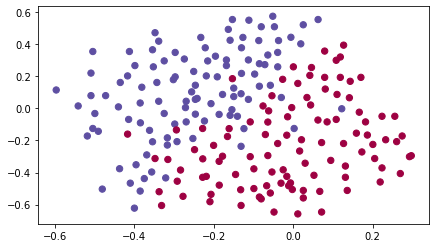

In [5]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

We will compare the regularized model with the non regularized one. Drop out and L2 norm are going to be used as regularization mechanisms

# Non regularized model
lambd is the regularization param lambda, and if that's 0, this means we won't use any regularization techniques

In [12]:
def model(X, Y, learning_rate = 0.3, num_iter = 30000, print_cost = True, lambd = 0, keep_prob = 1):
  grads = {}
  costs = []
  m = X.shape[1]
  layers_dims = [X.shape[0], 20,3,1]
  params = initialize_parameters(layers_dims) #he init

  #grad descent loop
  for i in range(0, num_iter):
    #dropout
    if keep_prob == 1:
      a3,cache = forward_propagation(X, params)
    else:
      a3,cache = forward_propagation_with_dropout(X,params,keep_prob)
    
    #L2 norm
    if lambd == 0:
      cost = compute_cost(a3, Y)
    else:
      cost = compute_cost_with_regularization(a3, Y, params, lambd)
    
    assert(lambd == 0 or keep_prob == 1) #but it's possible to use both

    if lambd == 0 and keep_prob == 1: #non regularized model
      grads = backward_propagation(X, Y, cache)
    elif lambd != 0:
      grads = backward_propagation_with_regularization(X, Y, cache, lambd)
    elif keep_prob < 1:
      grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
    
    params = update_parameters(params, grads, learning_rate)

    if print_cost and i % 10000 == 0:
          print(f"Cost after iteration {i}: {cost}")
    if print_cost and i % 1000 == 0:
          costs.append(cost)

  plt.plot(costs)
  plt.ylabel('cost')
  plt.xlabel('iterations (x1,000)')
  plt.title("Learning rate =" + str(learning_rate))
  plt.show()

  return params

    

Let's see how the non regularized model performs

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.1632998752572417
Cost after iteration 20000: 0.13851642423284755


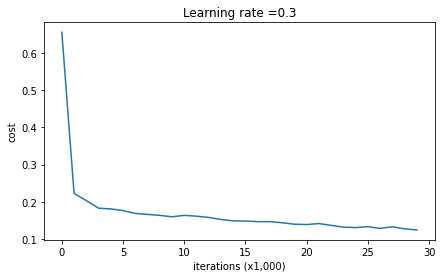

on training set
Accuracy: 0.9478672985781991
on test set
Accuracy: 0.915


<ipython-input-3-822bc4a139f0>:205: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p = np.zeros((1, m), dtype=np.int)


In [13]:
params = model(train_X, train_Y)
print("on training set")
predictions_train = predict(train_X, train_Y, params)
print("on test set")
predictions_test = predict(test_X, test_Y, params)


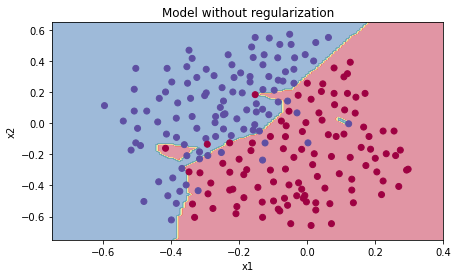

In [14]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
plot_decision_boundary(lambda x: predict_dec(params, x.T), train_X, train_Y)

This is called a baseline model and it has achieved and accuracy of 0.915 on the test set. Now let's see how and if regularization help us improve this model.
This model, even with high accuracy, is overfitting on the training data since it's fitting very noisy points on the graph shown above.

L2 norm is simply penalizing the model for having high values for the weights. It does this by adding the Frobenius norm of the W matrix i.e sum of the squares of the values and scaling that norm by a factor of lambda which is a hyperparameter

In [15]:
def compute_cost_with_regularization(A3, Y, params, lambd):
  m = Y.shape[1]
  W1 = params['W1']
  W2 = params['W2']
  W3 = params['W3']

  cross_entropy_cost = compute_cost(A3, Y)
  L2_cost = lambd * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))) / (2 * m)
  cost = cross_entropy_cost + L2_cost
  return cost

In [18]:
def backward_propagation_with_regularization(X, Y, cache, lambd):

    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = 1. / m * np.dot(dZ3, A2.T) + (lambd * W3) / m
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    
    dW2 = 1. / m * np.dot(dZ2, A1.T) + (lambd * W2) / m
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))

    dW1 = 1. / m * np.dot(dZ1, X.T) + (lambd * W1) / m
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients


Let's try this model out

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.26849188732822393
Cost after iteration 20000: 0.2680916337127301


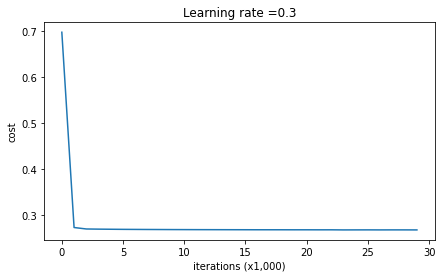

On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


<ipython-input-3-822bc4a139f0>:205: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p = np.zeros((1, m), dtype=np.int)


In [19]:
params = model(train_X, train_Y, lambd=0.7)
print("On the train set:")
predictions_train = predict(train_X, train_Y, params)
print("On the test set:")
predictions_test = predict(test_X, test_Y, params)

Hyperparameter lambda can be further optimized on the dev set. The larger its value, the smoother the function the model is fitting i.e. weights are smaller. However a larger value of lambda can lead the model to oversmooth i.e. underfit the data resulting in a model with high bias.

# Dropout
We are going to randomly shut off neurons while we pass through the network. This will cause the neurons to not rely too much on its previous connections and try to utilize each of its previous connections equally because any of them can get randomly shut off.

In [20]:
def forward_propagation_with_dropout(X, params, keep_prob = 0.5):
  np.random.seed(1)
  W1 = params["W1"]
  b1 = params["b1"]
  W2 = params["W2"]
  b2 = params["b2"]
  W3 = params["W3"]
  b3 = params["b3"]

  Z1 = np.dot(W1,X) + b1
  A1 = relu(Z1)

  D1 = np.random.rand(A1.shape[0], A1.shape[1])
  D1 = D1 < keep_prob #its values are now either 0 or 1
  A1 = A1 * D1
  A1 = A1 / keep_prob

  Z2 = np.dot(W2,A1) + b2
  A2 = relu(Z2)

  D2 = np.random.rand(A2.shape[0], A2.shape[1])     
  D2 = D2 < keep_prob                          
  A2 = A2 * D2  

  Z3 = np.dot(W3, A2) + b3
  A3 = sigmoid(Z3)

  cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
  
  return A3, cache



In [23]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
  m = X.shape[1]
  (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
  
  dZ3 = A3 - Y
  dW3 = 1./m * np.dot(dZ3, A2.T)
  db3 = 1./m * np.sum(dZ3, axis = 1, keepdims = True)
  dA2 = np.dot(W3.T, dZ3)

  dA2 = dA2 * D2 #apply the same mask to shut off the same neurons
  dA2 = dA2 / keep_prob #amplify the neurons that haven't been shut off

  dZ2 = np.multiply(dA2, np.int64(A2 > 0))
  dW2 = 1. / m * np.dot(dZ2, A1.T)
  db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
  
  dA1 = np.dot(W2.T, dZ2)
  dA1 = dA1 * D1
  dA1 = dA1 / keep_prob

  dZ1 = np.multiply(dA1, np.int64(A1 > 0))
  dW1 = 1./m * np.dot(dZ1, X.T)
  db1 = 1./m * np.sum(dZ1, axis = 1, keepdims = True)

  gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
  return gradients

Cost after iteration 0: 0.6591802509628507


<ipython-input-3-822bc4a139f0>:239: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3), Y) + np.multiply(-np.log(1 - a3), 1 - Y)
<ipython-input-3-822bc4a139f0>:239: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3), Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after iteration 10000: 0.051384980158585454
Cost after iteration 20000: 0.05061828024475211


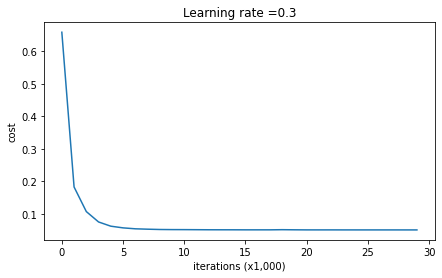

On the train set:
Accuracy: 0.9289099526066351
On the test set:
Accuracy: 0.945


<ipython-input-3-822bc4a139f0>:205: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p = np.zeros((1, m), dtype=np.int)


In [24]:
params = model(train_X, train_Y, keep_prob=0.86, learning_rate=0.3)

print("On the train set:")
predictions_train = predict(train_X, train_Y, params)
print("On the test set:")
predictions_test = predict(test_X, test_Y, params)

This model performs even better, it achieves 95% accuracy without overfitting. How can we know that? By plotting the decision boundary

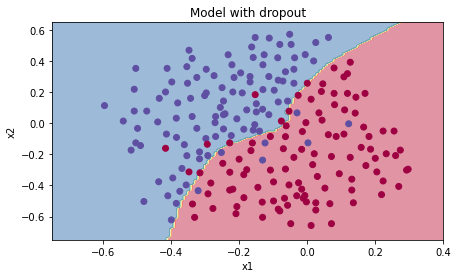

In [27]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
plot_decision_boundary(lambda x: predict_dec(params, x.T), train_X, train_Y)